In [100]:
import sys
sys.path.append('/home/ardelalegre/SoundMapping/Analysis/Util')
sys.path.append('/home/ardelalegre/SoundMapping/Database')
from DatabaseAPI import DatabaseAPI
import numpy as np
import matplotlib.pyplot as plt
from get_time_interval_data import *
from PCA import *
from Plot import *
from sklearn.cluster import KMeans

In [2]:
def find_center_kmeans(data,n_clusters=3):
    kmeans = KMeans(n_clusters, random_state=0).fit(data)
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    ind = np.argmax(counts)
    center = kmeans.cluster_centers_[ind]
    return center

#### Preprocess data

In [143]:
# Calibrated timestamp for Aug 19th, 11:10 - 11:20 am
min_data_ls = []
minute = 0
# From point 0 to point 10, group minute data
for i in range(5):
    start_str = 'Aug 19 2020 11:1{}:05AM'.format(i)
    end_str   = 'Aug 19 2020 11:1{}:50AM'.format(i)
    min_data_ls.append(get_time_interval_matrix_data(start_str,end_str))

In [145]:
min_data = np.vstack(min_data_ls)
min_data_len = np.array([data.shape[0] for data in min_data_ls])
# Obtain data list
min_data_ind = [int(np.sum(min_data_len[:i])) for i in range(6)]

In [146]:
cdata = get_cdata(min_data)
projection = project_to_eigen_vectors(cdata, 2, EIGEN_VALUES_0819, EIGEN_VECTORS_0819)

/home/ardelalegre/SoundMapping/Analysis/Util/PCA.py:43: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data[:,1:],axis = 0,keepdims = True)


#### Apply k-means to find the center of each minute cluster

In [149]:
center = np.asarray([find_center_kmeans(projection[min_data_ind[i]:min_data_ind[i+1],:]) for i in range(5)])

Findings: in Audacity, for the first and the second minute, a couple arrays did not have recordings due to unknown reasons, and thus data matrix are filled with nans. The third to fifth minute are filled with recordings. When applied K-means on data from each minute, the number of points in each cluster (2 are used) is very distinct from 3rd minute onwards

#### Room space: (x, y) positions of all points 0 to 9

In [148]:
p_0 = [0,0]
p_1 = [1.2,-0.6]
p_2 = [0,-0.6]
p_3 = [-1.2,-0.6]
p_4 = [1.2,0.6]
p_5 = [0,0.6]
p_6 = [-1.2,0.6]
p_7 = [1.2,1.8]
p_8 = [0,1.8]
p_9 = [-1.2,1.8]
room_space_coords_ls = [p_0, p_1, p_2, p_3, p_4, p_5, p_6, p_7, p_8, p_9]
room_space_coords = np.asarray(room_space_coords_ls)

### Affine transformation
#### Setup

* Room coordinates : $\vec{r}_i$ for $i=1:n$ $\vec{r}_i \in R^2$
* PCA coordinates : $\vec{v}_i$ for $i=1:n$ $\vec{v}_i \in R^{18}$

We choose $d$ the number of PCA coordinates to use. Probably $d=2,3,4$

We want an affine transformation which can be described by a matrix and a shoft vector.

$\vec{r} = \vec{s} + M \vec{v}$  where $\vec{s}$ is a 2 dimensional shift, and $M$ is a $2 \times d$ matrix

We can add a coordinate equal to $1$ to the vector $\vec{v}$ (call it $\vec{w}$) and add a column equal to $\vec{s}$ to the matrix $M$ (call is $G$)

Now we have an expressions of the form 

$ \vec{r}_i = G \vec{w}_i$

#### Solving

The $2(d+1)$ entries of $G$ the unknowns.

If $2(d+1) > n$ then we have an under-constrained system (there is an infinite number of solutions)

Define the regularization term $\|G\|$ as the sum of the squares of all entries in $G$.

If $2(d+1) < n$ then there is no solution (in general).

We can replace the equalities $ \vec{r}_i = G \vec{w}_i$ by an error:
$$\sum_i \| \vec{r}_i - G \vec{w}_i\|_2^2 $$

Combining this with the regularization term, we get

$$err(G) = \sum_i \| \vec{r}_i - G \vec{w}_i \|_2^2 + \|G\|$$ 

and our goal is to find $G$ with the minimal error.

$$
G = 
\begin{bmatrix}
G_{1,1} & G_{1,2} & \cdots & G_{1,{d+1}} \\
G_{2,1} & G_{2,2} & \cdots & G_{2,{d+1}}
\end{bmatrix}
$$

We find that the optimization of $err(G)$ can be written as two independent optimizations:
$$err_x(G) =  \sum_i \left( \begin{bmatrix}
G_{1,1} & G_{1,2} & \cdots & G_{1,{d+1}}
\end{bmatrix}
\vec{w}_i^T -\vec{r}_{i,1}
\right)^2 $$

$$err_y(G) =  \sum_i \left( \begin{bmatrix}
G_{2,1} & G_{2,2} & \cdots & G_{2,{d+1}}
\end{bmatrix}
\vec{w}_i^T -\vec{r}_{i,2}
\right)^2 $$

As the variables to be optimized for each error (the $G_i's$) are disjoint, each of $err_x,err_y$ can be optimized indpendently. 

The problem can be solved using closed-form solution (pseudo-inverse).

Self-check:
1. choose G and see if the algorithm returns the same G, give a known set of points

#### Defining matrices

In [150]:
N = 5
d = 2

$R$ should be a matrix consisting of all physical coordinates $r$ 

In [151]:
R = room_space_coords[:5]

Similarly, $W$ should be a matrix with all the d dimensional PCA points with a 1 appended to it.

In [152]:
W = np.vstack((center.T, np.ones(N)))

In [153]:
W.shape

(3, 5)

#### Model for X coordinates

In [154]:
Y = R[:N,0].reshape(-1,1)
X = W.T
model_x = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)

#### Model for Y coordinates

In [155]:
Y = R[:N,1].reshape(-1,1)
X = W.T
model_y = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)

In [157]:
# G is the transformation matrix
G = np.stack((model_x.T, model_y.T))
G = np.reshape(G, [2, d+1])

#### Map from PCA space to room space

In [158]:
to_project_mat = np.hstack((projection, np.ones((min_data.shape[0],1))))
projected_mat = G @ to_project_mat.T
transformed_centers = G @ W

In [167]:
# r = lambda: np.random.randint(0,255)
# color_ls = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(10)]
color_ls = ['r','b','g','y','m']

In [169]:
fixed_points_exp = get_time_interval_matrix_data('Aug 19 2020 11:10AM','Aug 19 2020 11:20AM')
cdata = get_cdata(fixed_points_exp)
fixed_points_proj = project_to_eigen_vectors(cdata, 2, EIGEN_VALUES_0819, EIGEN_VECTORS_0819)

/home/ardelalegre/SoundMapping/Analysis/Util/PCA.py:43: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data[:,1:],axis = 0,keepdims = True)


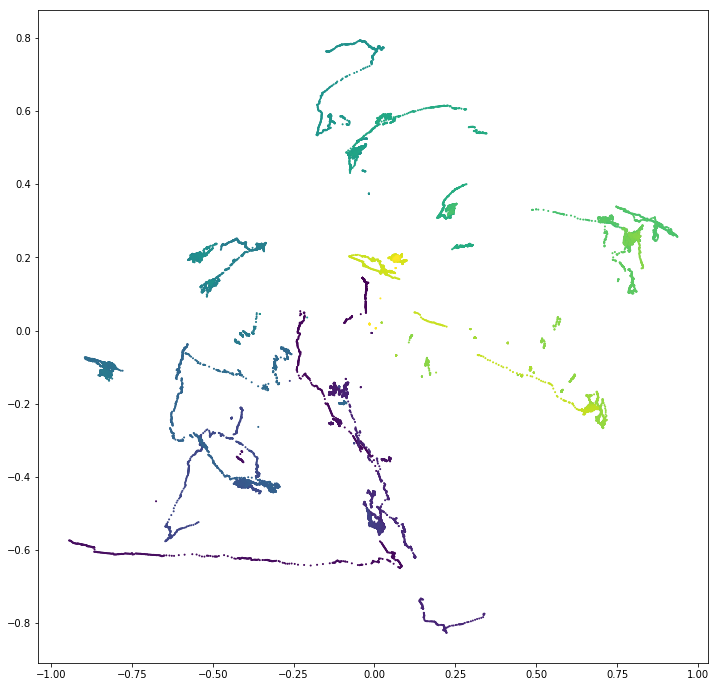

In [172]:
fig = plt.figure(figsize= (10,10))
ax = fig.add_subplot(111)
ax.scatter(fixed_points_proj[:,0],fixed_points_proj[:,1],s=1,c=np.arange(fixed_points_proj.shape[0]))

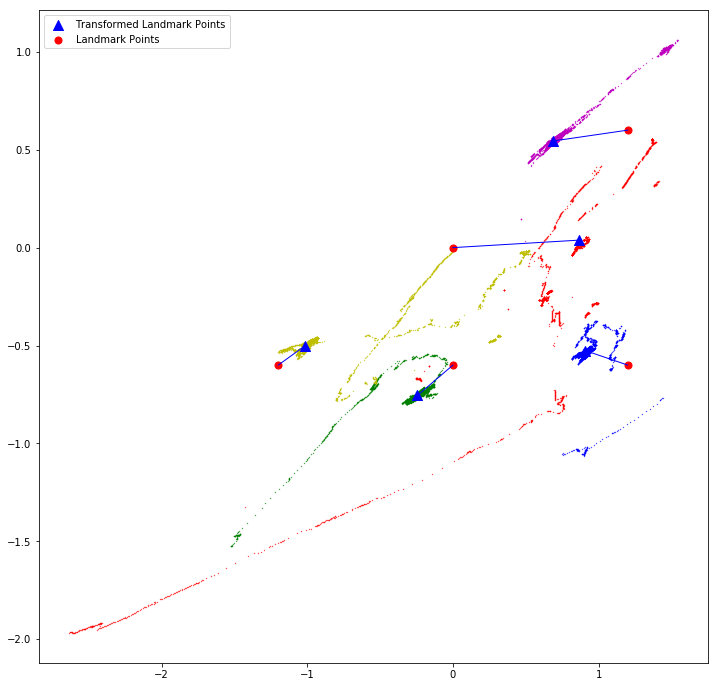

In [168]:
# d = 2
fig = plt.figure(figsize= (12,12))
ax1 = fig.add_subplot(111)
# Plot mapped PCA coordinates
for i in range(5):
    ax1.scatter(projected_mat[0,min_data_ind[i]:min_data_ind[i+1]],
                projected_mat[1,min_data_ind[i]:min_data_ind[i+1],],
                c=color_ls[i],
                s=0.1)

ax1.scatter(transformed_centers[0,:],transformed_centers[1,:],s=100,c="b", marker = '^', label = 'Transformed Landmark Points')
ax1.scatter(R[:,0], R[:,1],s = 50, c = 'r', label = 'Landmark Points')

for i in range(5):
    ax1.plot([R[i,0], transformed_centers.T[i,0]], [R[i,1],transformed_centers.T[i,1]], linewidth=1, c = 'blue')

lgnd = ax1.legend();

In [380]:
N = 10
part_W = minute_mean_array_np.T
ones = np.asarray([1.0 for i in range(N)])
W = np.vstack((part_W, ones))

# Model X
model_a_Y = R[:N,0]
model_a_Y = np.reshape(model_a_Y,(N,1))
model_a_X = W.T
param_x = np.dot(np.dot(np.linalg.inv(np.dot(model_a_X.T, model_a_X)), model_a_X.T), model_a_Y)

# Model Y
model_a_Y_2 = R[:N,1]
model_a_Y_2 = np.reshape(model_a_Y_2,(N,1))
model_a_X = W.T
param_y = np.dot(np.dot(np.linalg.inv(np.dot(model_a_X.T, model_a_X)), model_a_X.T), model_a_Y_2)

G = np.stack((param_x.T, param_y.T))
G = np.reshape(G, (2, d+1))

all_data_np = np.vstack(minute_arrays)
# append column of 1's to relevant data
one_long = np.ones((all_data_np.shape[0],1))
to_project_mat = np.hstack((all_data_np, one_long))
to_project_mat_correct_orientation = to_project_mat.T
projected_mat = G @ to_project_mat_correct_orientation

In [70]:
# plot d = 4
# fig = plt.figure(figsize= (15,15))
# ax = fig.add_subplot(111)
# ind0 = 0
# for i in range(N):
#     ind1 = ind0 + minute_arrays[i].shape[0]
#     lbl_string = 'minute ' + str(i)
#     ax.scatter(projected_mat[0,ind0:ind1],projected_mat[1,ind0:ind1],s=1, label = lbl_string)
#     ind0 = ind1
    
# ax.scatter(transformed_mean_points[0,:],transformed_mean_points[1,:],s=100,c="b", marker = '^', label = 'Transformed Landmark Points')
# ax.scatter(R[:,0], R[:,1],s = 50, c = 'r', label = 'Landmark Points')
# for i in range(N):
#     ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')
# lgnd = ax.legend();
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# lgnd.legendHandles[2]._sizes = [30]
# lgnd.legendHandles[3]._sizes = [30]
# lgnd.legendHandles[4]._sizes = [30]

# for i in range(N):
#     ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')

# ax.scatter(R[:,0], R[:,1],s = 100, c = 'r', label='Landmark points')
# for i in range(10):
#     ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')
# ax.set_title('Picture in room coordinates (4 eigenvectors used)')
# ax.legend();

In [ ]:
# Look at one second of measurement
# Average of a second
# Plot the average of 1 second 